In [ ]:
from google.colab import files
uploaded = files.upload()

Saving uav_raw.csv to uav_raw (2).csv


In [ ]:
# ===============================
# STEP 1: UAV RAW Dataset
# ===============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df=pd.read_csv("uav_raw.csv")

In [ ]:
df.head()

,timestamp,alt_baro_m,alt_gps_m,speed_kmh,ax_ms2,ay_ms2,az_ms2,battery_pct
0,2025-08-23 10:00:00.000,0.149014,0.576313,7.251281,0.042130,0.175696,9.738575,99.731522
1,2025-08-23 10:00:00.100,-0.011303,-1.236119,7.988776,-0.039250,-0.077078,9.923587,99.874583
2,2025-08-23 10:00:00.200,0.254660,1.047359,7.536488,-0.276784,0.039984,10.292355,99.429417
3,2025-08-23 10:00:00.300,0.547439,-1.065151,7.397261,-0.061630,0.367887,10.486877,100.000000
4,2025-08-23 10:00:00.400,0.050461,0.951363,7.129158,-0.012626,0.266436,9.909151,100.000000


**Why APIs are used with drones:**
Real-time operations: Subscribe to telemetry/health to monitor flights, trigger geofence actions, or return-to-home logic.

Mission planning & compliance: Query airspace/UTM and weather APIs before/during flight; log flights for audits.

Data pipelines: Move imagery/logs to storage, run analytics, and feed dashboards—automatically.

Endpoint: a URL (e.g., /telemetry), often grouped under a base URL (e.g., http://127.0.0.1:5000).

Method: GET (read), POST (create), PUT/PATCH (update), DELETE (remove).

Query params: ?start=...&end=...&rate=10Hz.

Headers: e.g., Authorization: Bearer <TOKEN>, Accept: application/json.

Body: JSON payload (mainly in POST/PUT).

Response: usually JSON → parse → validate → store.

In [ ]:

# Write the Flask app to a file
%%writefile drone_api.py
from flask import Flask, jsonify

app = Flask(__name__)

@app.route('/telemetry', methods=['GET'])
def telemetry():
    return jsonify({
        "latitude": 28.61,
        "longitude": 77.23,
        "altitude": 120,
        "speed": 12.5,
        "battery": 87
    })

if __name__ == "__main__":
    # Bind to localhost:5000
    app.run(host="127.0.0.1", port=5000, debug=False)

Overwriting drone_api.py


In [ ]:

# Write the Flask app
%%writefile drone_api.py
from flask import Flask, jsonify, request
import time, random

app = Flask(__name__)

@app.route('/telemetry', methods=['GET'])
def telemetry():
    """Return one telemetry sample or a short window if n>1."""
    n = int(request.args.get("n", 1))
    now = time.time()
    out = []
    for i in range(n):
        out.append({
            "ts": now + i*0.1,
            "latitude": 28.61 + random.uniform(-0.0008, 0.0008),
            "longitude": 77.23 + random.uniform(-0.0008, 0.0008),
            "altitude_m": 120 + random.uniform(-2, 2),
            "speed_ms": 12.0 + random.uniform(-1.0, 1.0),
            "battery_pct": random.randint(70, 100),
            "mode": random.choice(["MANUAL", "AUTO", "RTL"])
        })
    return jsonify(out if n > 1 else out[0])

if __name__ == "__main__":
    app.run(host="127.0.0.1", port=5000, debug=False)

Overwriting drone_api.py


In [ ]:
!nohup python -u drone_api.py >/dev/null 2>&1 &

In [ ]:
import time, requests

# Give the server a moment to start if needed
for _ in range(10):
    try:
        resp = requests.get("http://127.0.0.1:5000/telemetry", timeout=1.0)
        break
    except Exception:
        time.sleep(0.5)

print(resp.status_code, resp.json())

200 {'altitude_m': 118.44564560140326, 'battery_pct': 84, 'latitude': 28.61072955073011, 'longitude': 77.22925412163632, 'mode': 'RTL', 'speed_ms': 11.798321746575049, 'ts': 1755966022.7509637}


In [ ]:
import time, requests

# simple retry loop to wait for server
for _ in range(10):
    try:
        r = requests.get("http://127.0.0.1:5000/telemetry?n=5", timeout=1.0)
        break
    except Exception:
        time.sleep(0.5)

print("Status:", r.status_code)
print("One sample:", r.json()[0])

Status: 200
One sample: {'altitude_m': 118.73787282078042, 'battery_pct': 89, 'latitude': 28.609695381455744, 'longitude': 77.229370309644, 'mode': 'MANUAL', 'speed_ms': 11.649697256745569, 'ts': 1755965680.5682366}


In [ ]:
import pandas as pd

data = r.json()
df = pd.DataFrame(data)
# Basic validation/cleanup
expected_cols = {'ts','latitude','longitude','altitude_m','speed_ms','battery_pct','mode'}
missing = expected_cols - set(df.columns)
assert not missing, f"Missing fields: {missing}"

df = df.sort_values('ts').reset_index(drop=True)
df.head()

,altitude_m,battery_pct,latitude,longitude,mode,speed_ms,ts
0,118.737873,89,28.609695,77.229370,MANUAL,11.649697,1.755966e+09
1,121.093034,95,28.610127,77.229387,AUTO,11.385765,1.755966e+09
2,121.342181,74,28.609689,77.230352,AUTO,11.130514,1.755966e+09
3,120.970005,80,28.610769,77.229264,AUTO,12.082348,1.755966e+09
4,118.596720,75,28.610727,77.229554,MANUAL,11.329002,1.755966e+09


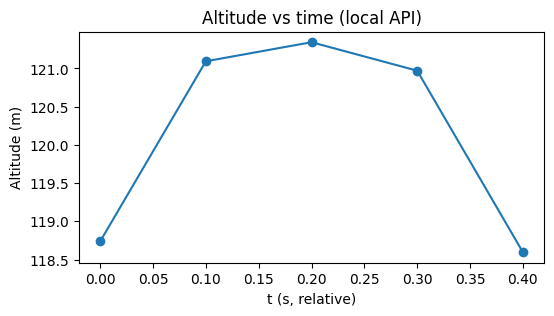

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
plt.plot(df['ts']-df['ts'].iloc[0], df['altitude_m'], marker='o')
plt.xlabel("t (s, relative)")
plt.ylabel("Altitude (m)")
plt.title("Altitude vs time (local API)")
plt.show()

In [ ]:
import os, signal, subprocess, sys, re, psutil, textwrap
# Quick-and-dirty: kill python processes running drone_api.py
for p in psutil.process_iter(attrs=["pid","name","cmdline"]):
    try:
        if p.info["cmdline"] and "drone_api.py" in " ".join(p.info["cmdline"]):
            os.kill(p.info["pid"], signal.SIGTERM)
    except Exception:
        pass
print("Attempted to stop drone_api.py")

Attempted to stop drone_api.py


**Pre-processing**

Raw data is often messy, so it must be prepared before analysis:

Cleaning noisy data,Noise = random errors or irrelevant data.

Handling inconsistent data

Handling missing values

Fill (impute) with mean/median/mode.

Normalization / Scaling

Data Transformation

Feature Extraction


In [ ]:
# ===============================
# STEP 2: Preprocess the UAV Dataset
# ===============================

df = pd.read_csv("uav_raw.csv", parse_dates=["timestamp"])
#df.head()
df.set_index("timestamp", inplace=True)
df.head()

,alt_baro_m,alt_gps_m,speed_kmh,ax_ms2,ay_ms2,az_ms2,battery_pct
timestamp,,,,,,,
2025-08-23 10:00:00.000,0.149014,0.576313,7.251281,0.042130,0.175696,9.738575,99.731522
2025-08-23 10:00:00.100,-0.011303,-1.236119,7.988776,-0.039250,-0.077078,9.923587,99.874583
2025-08-23 10:00:00.200,0.254660,1.047359,7.536488,-0.276784,0.039984,10.292355,99.429417
2025-08-23 10:00:00.300,0.547439,-1.065151,7.397261,-0.061630,0.367887,10.486877,100.000000
2025-08-23 10:00:00.400,0.050461,0.951363,7.129158,-0.012626,0.266436,9.909151,100.000000


**What does interpolate function do?**

Interpolate = fill missing values by estimating them.

Example (GPS dropouts):

Time: 10s   11s   12s   13s

GPS: 100m   NaN   NaN   112m

Linear interpolation will fill:

10s → 100m
11s → 104m
12s → 108m
13s → 112m

In UAVs: GPS may miss signals for 2–3 seconds. Instead of leaving gaps, we interpolate to smoothly estimate position/altitude until next valid reading arrives.


In [ ]:
# --- Handle Missing Values ---
df["alt_gps_m"].interpolate(method="time", inplace=True)
df["battery_pct"].interpolate(limit_direction="both", inplace=True)
df['alt_gps_m'].head()

/tmp/ipython-input-2883253073.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["alt_gps_m"].interpolate(method="time", inplace=True)
/tmp/ipython-input-2883253073.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

,alt_gps_m
timestamp,
2025-08-23 10:00:00.000,0.576313
2025-08-23 10:00:00.100,-1.236119
2025-08-23 10:00:00.200,1.047359
2025-08-23 10:00:00.300,-1.065151
2025-08-23 10:00:00.400,0.951363


limit_direction="forward"

It can fill gaps that come after known values. 30 40 Nan -> 30 40 50

limit_direction="backward"

It can fill gaps that come before known values. Nan 30 50 -> 40 30 50

imit_direction="both"

Combines forward + backward

Nan 30 50 Nan -> 40 30 50 60

In [ ]:
# --- Fix Units (speed km/h → m/s) ---
df["speed_ms"] = df["speed_kmh"] / 3.6
df['speed_ms']


,speed_ms
timestamp,
2025-08-23 10:00:00.000,2.014245
2025-08-23 10:00:00.100,2.219104
2025-08-23 10:00:00.200,2.093469
2025-08-23 10:00:00.300,2.054795
2025-08-23 10:00:00.400,1.980322
...,...
2025-08-23 10:04:59.500,1.750331
2025-08-23 10:04:59.600,2.069784
2025-08-23 10:04:59.700,1.859739


**What is the use of Sensor Fusion?**

One sensor ≠ perfect:

GPS → accurate long-term, but noisy and slow updates.

Barometer → good short-term, but drifts.

Sensor Fusion = combine strengths, cancel weaknesses.

Example:

GPS says altitude = 20 ± 2m (slow, noisy).

Baro says altitude = 20 ± 0.3m but drifts slowly.

Fusion (e.g., complementary filter, Kalman filter) gives smooth + accurate altitude.

 Without fusion: Drone may think it’s climbing when it’s not → wrong flight control.

In [ ]:

alpha = 0.7
df["alt_fused_m"] = alpha*df["alt_baro_m"] + (1-alpha)*df["alt_gps_m"]

**Feature engineering**  = extracting useful signals from raw data.

From raw accelerometer (ax, ay, az) → compute roll & pitch angles.

From GPS positions → compute velocity & acceleration.

From battery voltage curve → compute estimated remaining flight time.

*Importance:*

Improves model accuracy: Good features = better predictions.

Reduces noise: Condensing raw noisy data into meaningful features.

Domain knowledge: Uses physics/engineering knowledge of drones to guide ML.

In [ ]:
# --- Feature Engineering: Tilt ---
df["roll_deg"] = np.degrees(np.arctan2(df["ay_ms2"], df["az_ms2"]))
df["pitch_deg"] = np.degrees(np.arctan2(-df["ax_ms2"], np.sqrt(df["ay_ms2"]**2 + df["az_ms2"]**2)))


In [ ]:
# Save cleaned dataset
df.to_csv("uav_cleaned.csv")
print(" Cleaned UAV dataset saved: uav_cleaned.csv")
df.head(10)

 Cleaned UAV dataset saved: uav_cleaned.csv


,alt_baro_m,alt_gps_m,speed_kmh,ax_ms2,ay_ms2,az_ms2,battery_pct,speed_ms,alt_fused_m,roll_deg,pitch_deg
timestamp,,,,,,,,,,,
2025-08-23 10:00:00.000,0.149014,0.576313,7.251281,0.042130,0.175696,9.738575,99.731522,2.014245,0.277204,1.033572,-0.247825
2025-08-23 10:00:00.100,-0.011303,-1.236119,7.988776,-0.039250,-0.077078,9.923587,99.874583,2.219104,-0.378748,-0.445018,0.226607
2025-08-23 10:00:00.200,0.254660,1.047359,7.536488,-0.276784,0.039984,10.292355,99.429417,2.093469,0.492470,0.222583,1.540428
2025-08-23 10:00:00.300,0.547439,-1.065151,7.397261,-0.061630,0.367887,10.486877,100.000000,2.054795,0.063662,2.009152,0.336509
2025-08-23 10:00:00.400,0.050461,0.951363,7.129158,-0.012626,0.266436,9.909151,100.000000,1.980322,0.320731,1.540191,0.072979
2025-08-23 10:00:00.500,0.080643,1.477050,7.467415,-0.136707,0.121655,9.509089,100.000000,2.074282,0.499565,0.732974,0.823587
2025-08-23 10:00:00.600,0.654824,1.213784,6.966601,0.338607,-0.182921,10.002980,100.000000,1.935167,0.822512,-1.047632,-1.938431
2025-08-23 10:00:00.700,0.441467,0.511650,6.885711,0.254760,0.160409,9.445687,100.000000,1.912697,0.462522,0.972920,-1.544728
2025-08-23 10:00:00.800,0.100571,-0.037481,6.939960,0.236063,0.172020,9.630643,99.740878,1.927767,0.059156,1.023291,-1.403907


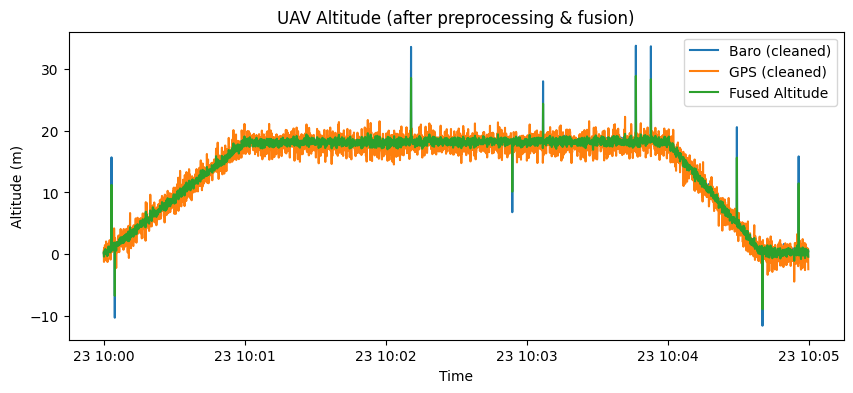

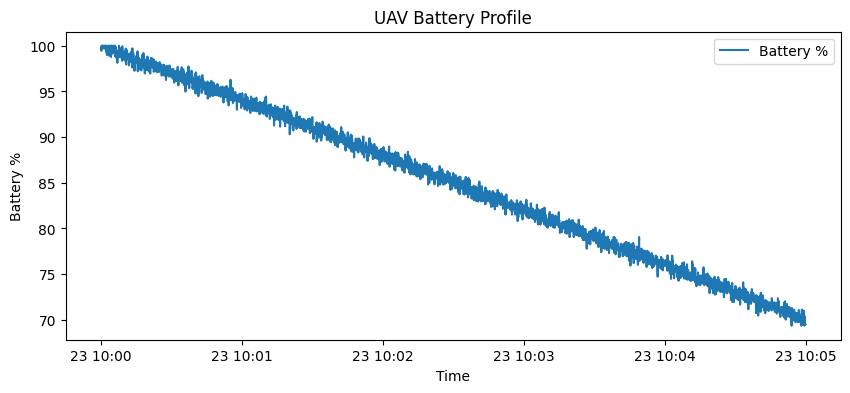

In [ ]:
# ===============================
# STEP 3: Visualization
# ===============================

plt.figure(figsize=(10,4))
plt.plot(df.index, df["alt_baro_m"], label="Baro (cleaned)")
plt.plot(df.index, df["alt_gps_m"], label="GPS (cleaned)")
plt.plot(df.index, df["alt_fused_m"], label="Fused Altitude")
plt.title("UAV Altitude (after preprocessing & fusion)")
plt.xlabel("Time")
plt.ylabel("Altitude (m)")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df.index, df["battery_pct"], label="Battery %")
plt.title("UAV Battery Profile")
plt.xlabel("Time")
plt.ylabel("Battery %")
plt.legend()
plt.show()


The visualization proves that sensor fusion provides a stable and accurate UAV altitude estimate — better than relying on either barometer or GPS alone.